### Pipeline for a single spikeglx session
- Load an exctractor for visualization of the data
- Sort it using kilosort

In [1]:
%matplotlib inline
import os
import glob
import logging
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [2]:
os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

from ceciestunepipe.file import filestructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

In [3]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-05-28 23:08:46,978 root         INFO     all modules loaded


### Session parameters and raw files

In [4]:
reload(et)

bird = 'z_w12m7_20'
all_bird_sess = et.list_sessions(bird)
all_bird_sess

['20201105', '20201106', '20201104']

In [5]:

sess_par = {'bird': 'z_w12m7_20',
           'sess': '20201105',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['raw']

In [6]:
sess_epochs = sglu.list_sgl_epochs(sess_par)
sess_epochs

2021-05-28 23:09:04,180 ceciestunepipe.util.sglxutil INFO     {'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20', 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201105', 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201105', 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201105', 'derived': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/derived/20201105', 'tmp': '/scratch/earneodo/tmp/tmp', 'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201105', 'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201105'}, 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201105/params.json', 'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201105/settings.isf', 'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201105/rig.json', 'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201105/stream.

['dir_g0', 'dir_m101_extref_g0', 'dir_m101_g0']

In [29]:
### pick a session
reload(et)
reload(sglu)
epoch = sess_epochs[2] # g2 is the shortest

exp_struct = sglu.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['raw'])

In [30]:
sgl_folders

{'nidq': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201105/dir_m101_g0',
 'imec_0': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201105/dir_m101_g0/dir_m101_g0_imec0'}

In [31]:
sgl_files

{'nidq': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201105/dir_m101_g0/dir_m101_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201105/dir_m101_g0/dir_m101_g0_imec0/dir_m101_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201105/dir_m101_g0/dir_m101_g0_imec0/dir_m101_g0_t0.imec0.ap.meta']}

In [32]:
files_pd = pd.DataFrame(sgl_files)

In [33]:
files_pd

nidq  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                                lf_0  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                                ap_0  
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...

In [34]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}


#probe_data_folder = sgl_folder['imec'][probe_id]


### view the nidaq data

In [35]:
run_recordings['nidq']

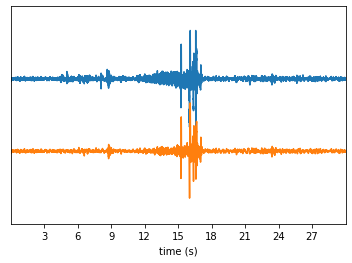

In [36]:
w_ts = sw.plot_timeseries(run_recordings['nidq'], channel_ids=[0, 7], trange=[0,30])

In [37]:
nidq_ttl = run_recordings['nidq'].get_ttl_events()

2021-05-29 08:46:54,614 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [38]:
run_recordings['lf_0']._raw.shape

(385, 1304294)

In [39]:
syn_ch_arr = run_recordings['lf_0']._raw[-1, :]

np.mean(syn_ch_arr)

31.98444522477294

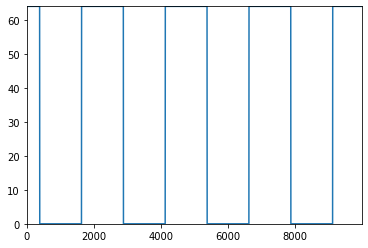

In [40]:
plt.plot(syn_ch_arr[:10000])

In [41]:
run_recordings['ap_0']._meta

{'acqApLfSy': '384,384,1',
 'appVersion': '20200520',
 'fileCreateTime': '2020-11-05T14:48:12',
 'fileName': 'D:/experiment/raw_data/z_w12m7_20/20201105/dir_m101_g0/dir_m101_g0_imec0/dir_m101_g0_t0.imec0.ap.bin',
 'fileSHA1': '7A6BAC92C5C96048D01F2217C98B32487919C810',
 'fileSizeBytes': '12051668860',
 'fileTimeSecs': '521.717836608622',
 'firstSample': '565642',
 'gateMode': 'Immediate',
 'imAiRangeMax': '0.6',
 'imAiRangeMin': '-0.6',
 'imCalibrated': 'true',
 'imDatApi': '1.20',
 'imDatBs_fw': '1.1.123',
 'imDatBsc_fw': '1.0.151',
 'imDatBsc_hw': '5.1',
 'imDatBsc_pn': 'NP2_HS_30',
 'imDatBsc_sn': '567',
 'imDatFx_hw': '1.2',
 'imDatFx_pn': 'NP2_FLEX_0',
 'imDatHs_fw': '5.2',
 'imDatHs_pn': 'NP2_HS_30',
 'imDatHs_sn': '1807',
 'imDatPrb_pn': 'PRB_1_4_0480_1',
 'imDatPrb_port': '4',
 'imDatPrb_slot': '2',
 'imDatPrb_sn': '19108322052',
 'imDatPrb_type': '0',
 'imLEDEnable': 'false',
 'imMaxInt': '512',
 'imRoFile': 'D:/experiment/raw_data/audio_test/lf_250x_tipref.imro',
 'imSampRate

## The digital and sync channel in the recording
- using the new methods in my version of readSGLX, spikeglxrecordingextractor

2021-05-29 08:47:05,906 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


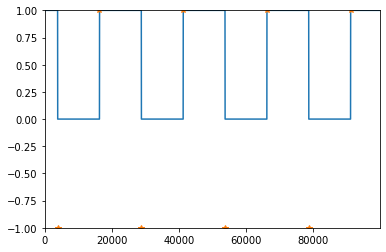

In [42]:
### the digital chan and the syn extraction of the nidq rec

nidq_syn = rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, 100000, 0, [0], run_recordings['nidq']._meta)
nidq_syn_ttl = run_recordings['nidq'].get_ttl_events(channel_id=0, end_frame=100000)

plt.plot(nidq_syn.flatten())
plt.plot(*nidq_syn_ttl, '*')

2021-05-29 08:47:06,026 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-05-29 08:47:06,028 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (100000,)
2021-05-29 08:47:06,911 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 31.73376
2021-05-29 08:47:06,914 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-05-29 08:47:06,915 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-05-29 08:47:06,916 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (100000,)
2021-05-29 08:47:

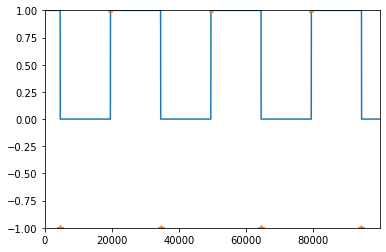

In [43]:
### the digital chan and the syn extraction of the nidq rec
ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, 100000, 0, [0], run_recordings['ap_0']._meta)
ap_syn_ttl = run_recordings['ap_0'].get_ttl_events(end_frame=100000)

plt.plot(ap_syn.flatten())
plt.plot(*ap_syn_ttl, '*')

In [44]:
exp_struct

{'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/dir_m101_g0',
  'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201105/dir_m101_g0',
  'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201105/dir_m101_g0',
  'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201105/dir_m101_g0',
  'derived': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/derived/20201105/dir_m101_g0',
  'tmp': '/scratch/earneodo/tmp/tmp/dir_m101_g0',
  'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201105/dir_m101_g0',
  'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201105/dir_m101_g0'},
 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201105/dir_m101_g0/params.json',
  'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201105/settings.isf',
  'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201105/rig.json',
  'kwd': '/mnt/sp

##### get the microphone channel

In [45]:
from ceciestunepipe.util.sound import spectral as sp
from scipy.io import wavfile

In [46]:
mic_chan_id = [0]

mic_stream = run_recordings['nidq'].get_traces(channel_ids=mic_chan_id)

In [47]:
mic_stream.shape

(1, 13042785)

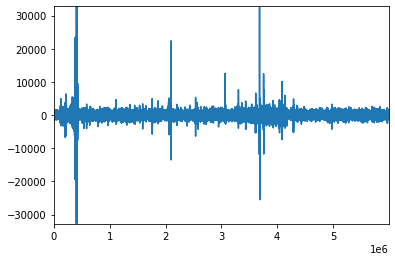

In [48]:
plt.plot(mic_stream[0, :6000000])

In [49]:
s_f = run_recordings['nidq'].get_sampling_frequency()

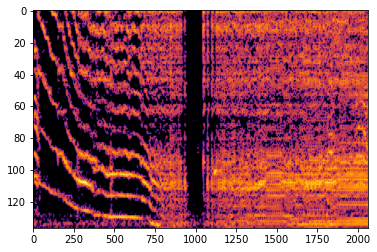

In [50]:
reload(sp)
f, t, s = sp.ms_spectrogram(mic_stream[0, 300000:350000], s_f)
plt.imshow(np.log(s[::-1]), aspect='auto', cmap='inferno')

In [51]:
mic_file_name = os.path.join(exp_struct['folders']['processed'], 'wav_mic.wav')
mic_file_name

'/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201105/dir_m101_g0/wav_mic.wav'

In [52]:
from scipy.io import wavfile

In [54]:
def mic_to_wav(recording_extractor, mic_chan_list: list, wav_path:str):
    # get the stream
    mic_stream = recording_extractor.get_traces(channel_ids=mic_chan_list)
    # make sure folder exists
    logger.info('saving {}-shaped array as wav in {}'.format(mic_stream.shape, wav_path))
    os.makedirs(os.path.split(wav_path)[0], exist_ok=True)
    # write it
    s_f = int(recording_extractor.get_sampling_frequency())
    wavfile.write(wav_path, s_f, mic_stream.T)
    
mic_to_wav(run_recordings['nidq'], mic_chan_id, mic_file_name)

2021-05-29 08:50:48,088 root         INFO     saving (1, 13042785)-shaped array as wav in /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201105/dir_m101_g0/wav_mic.wav


#### match_template

In [28]:
s_f
n_window = 128

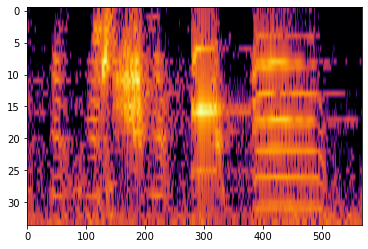

In [33]:
temp_start_sample = int(12.83 * s_f)
temp_end_sample = temp_start_sample + int(s_f*0.55)

template1 = mic_stream[0, temp_start_sample: temp_end_sample]

f, t, s1 = sp.ms_spectrogram(template1, s_f, n_window)

#plt.plot(template)
plt.imshow(np.log(s1[::-1]), aspect='auto', cmap='inferno')

In [34]:
s1.shape

(34, 568)

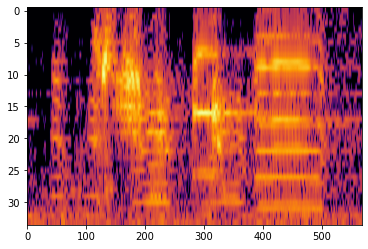

In [35]:
temp_start_sample = int(13.35 * s_f)
temp_end_sample = temp_start_sample + int(s_f*0.55)

template2 = mic_stream[0, temp_start_sample: temp_end_sample]

f, t, s2 = sp.ms_spectrogram(template2, s_f, n_window)

#plt.plot(template)
plt.imshow(np.log(s2[::-1]), aspect='auto', cmap='inferno')

In [36]:
s2.shape

(34, 568)

In [37]:
mic_stream.shape

(1, 191052384)

In [38]:
f, t, s_all = sp.ms_spectrogram(mic_stream[0, :30000*60], s_f, n_window=n_window)

In [39]:
s1.shape

(34, 568)

In [40]:
s_all.shape

(34, 74995)

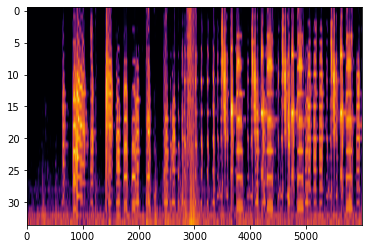

In [41]:
plt.imshow(np.log(s_all[:, 10000:16000][::-1]), aspect='auto', cmap='inferno')

In [42]:
from scipy import signal


In [43]:
s_some = s_all[:, 10000:16000]

##### rolling spectral diff

In [44]:
s_all.shape

(34, 74995)

In [45]:
s1.shape

(34, 568)

In [46]:
def spectral_diff(u, v):
    spec_diff = u / np.linalg.norm(u) - v / np.linalg.norm(v)
    return np.linalg.norm(spec_diff) / np.sqrt(spec_diff.size)

s_ref = spectral_diff(s1[:,15:], s1[:,:-15])
s_ref

0.008147466942960714

In [47]:
def spectral_diff(u, v):
    spec_diff = u / np.linalg.norm(u) - v / np.linalg.norm(v)
    return np.linalg.norm(spec_diff) / np.sqrt(spec_diff.size)

spectral_diff(s1, s2)

rms_t = np.array([spectral_diff(s1, s_some[:, i: i+s1.shape[1]]) for i in range(s_some.shape[1] - s1.shape[1])])

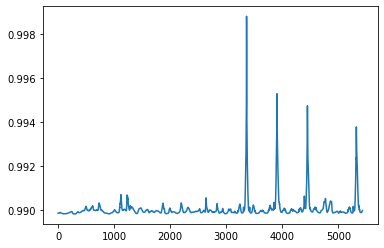

In [48]:
plt.plot(1 - rms_t)

In [49]:
def match_template(x, template, s_f, f_min=300, f_max=7000, n_window=128, threshold=None):
    # get the spectrogram of all of the signal
    # get the differences along the time axis
    # find peaks
    # if threshold is none, compute a reference that is the self-similarity of the pattern when shifted 20 ms
    
    # compute the difference between the template and the spectrogram
    
    # very inefficient (and memory consuming)
    logger.info('Getting spectrogram of the whole mic channel')
    
    f, t_all, s_all = sp.ms_spectrogram(x, s_f, f_min=f_min, f_max=f_max, n_window=n_window)
    
    f, t_temp, s_temp = sp.ms_spectrogram(template, s_f, f_min=f_min, f_max=f_max, n_window=n_window)
    
    if threshold is None:
        logger.info('no threhold was entered, will set it from self-similarity of pattern shifted 20ms')
        threshold = spectral_diff(s_temp[:,15:], s_temp[:,:-15])
        logger.info('threshold is {}'.format(threshold))
    
    n_s = s_temp.shape[1]
    n_a = s_all.shape[1]
    
    logger.info('getting spectral differences')
    dist_t = np.array([spectral_diff(s_temp, 
                                     s_all[:, i: i + n_s]) for i in range(n_a - n_s)])
    
    # make positive to find peaks
    inv_dist_t = 1 - dist_t
    inv_thresh = 1 - threshold
    
    peaks = signal.find_peaks(inv_dist_t, height=inv_thresh, distance=int(n_s*0.7))
    
    return peaks, s_temp, s_all, dist_t

p, s_temp, s_all, dist_t = match_template(mic_stream.flatten(), template1, s_f)


2021-01-30 19:37:20,923 root         INFO     Getting spectrogram of the whole mic channel
2021-01-30 19:38:27,203 root         INFO     no threhold was entered, will set it from self-similarity of pattern shifted 20ms
2021-01-30 19:38:27,205 root         INFO     threshold is 0.008147466942960714
2021-01-30 19:38:27,205 root         INFO     getting spectral differences


<ipython-input-50-1e48f37a3679>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


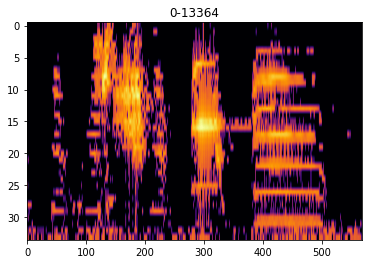

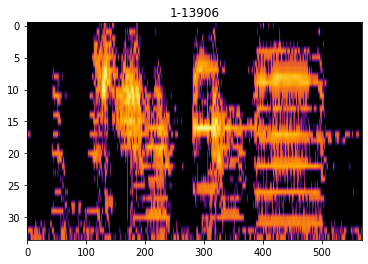

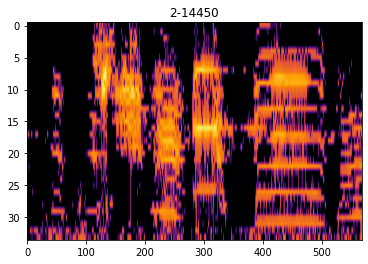

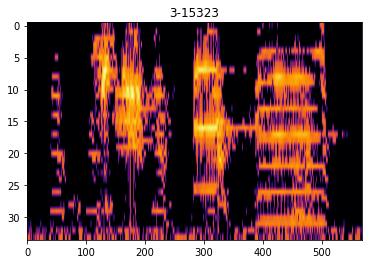

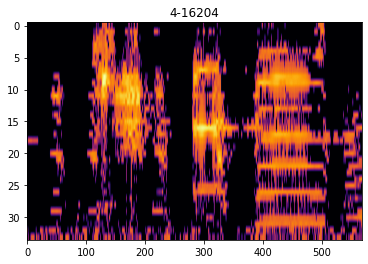

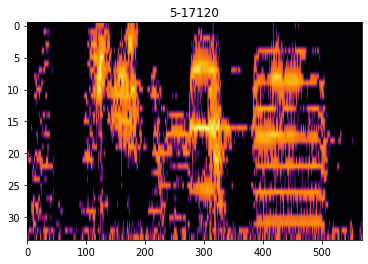

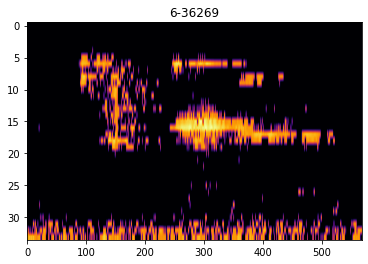

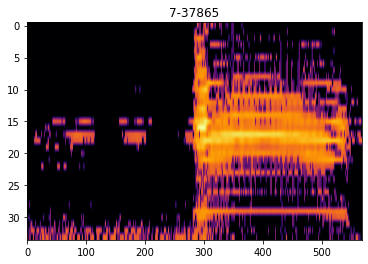

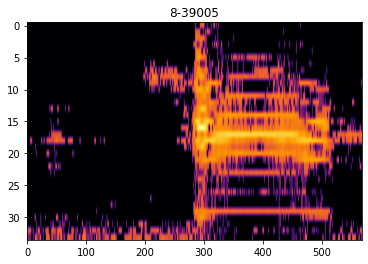

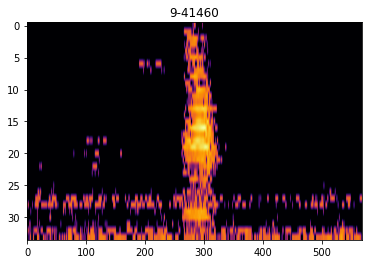

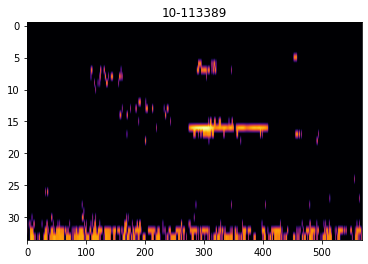

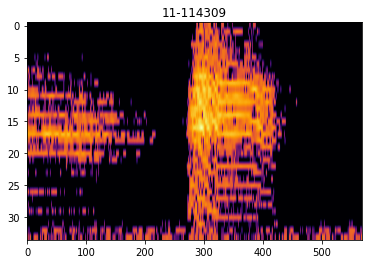

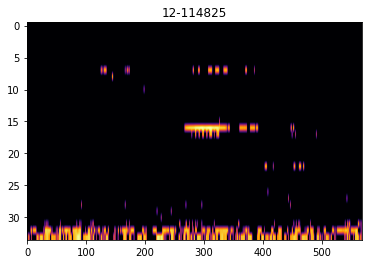

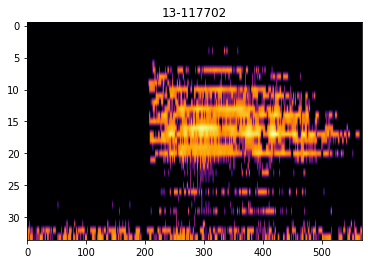

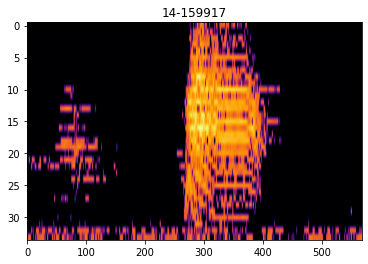

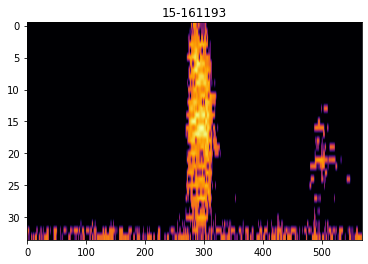

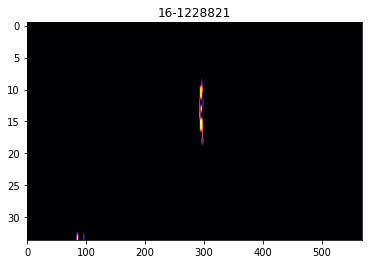

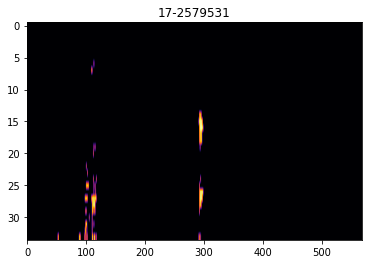

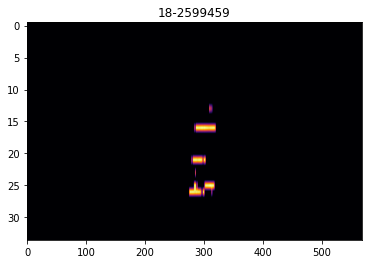

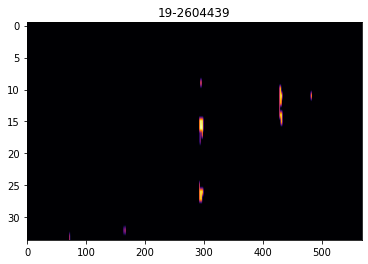

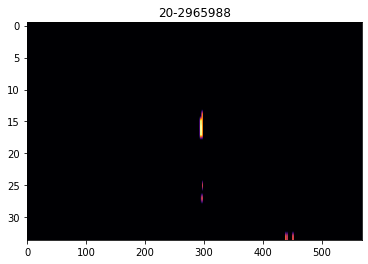

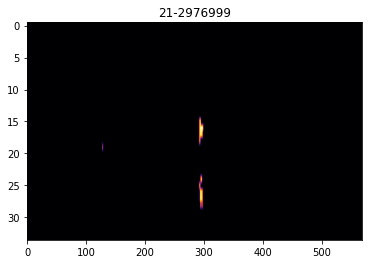

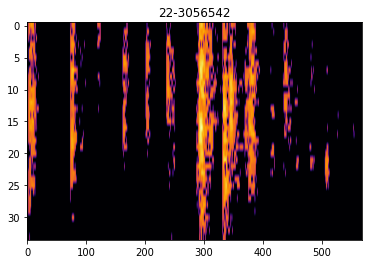

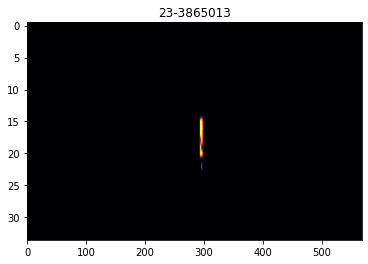

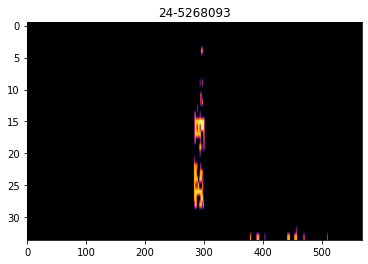

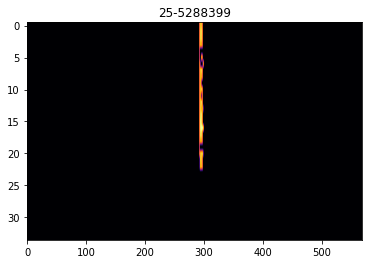

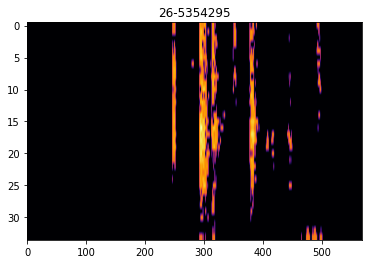

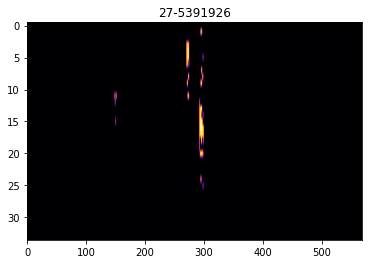

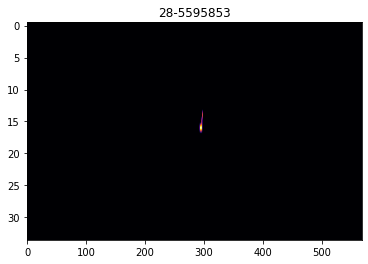

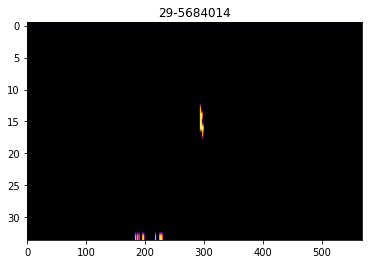

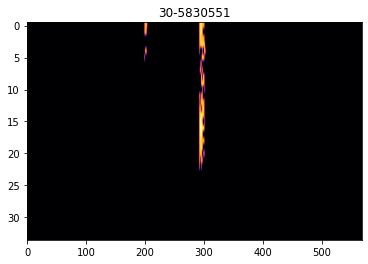

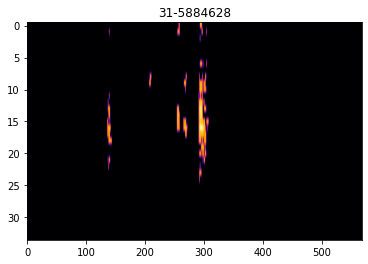

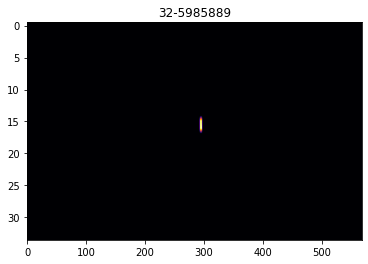

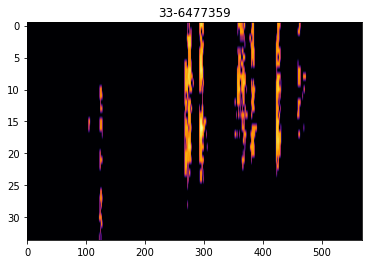

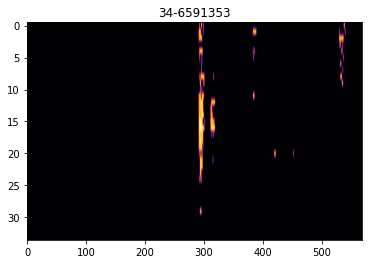

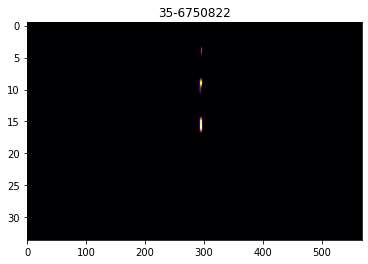

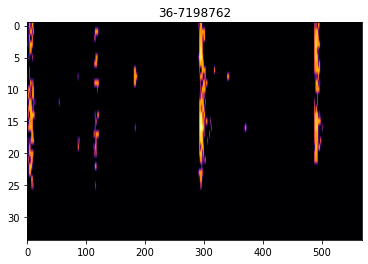

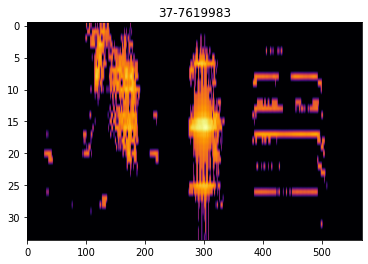

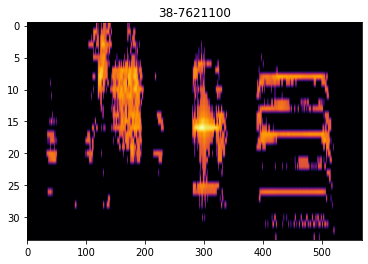

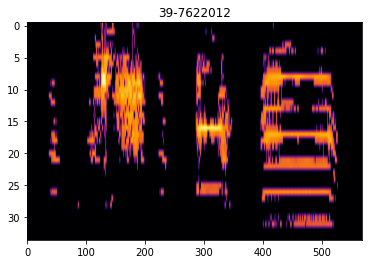

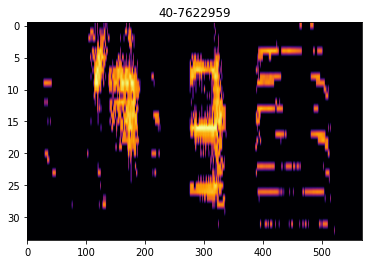

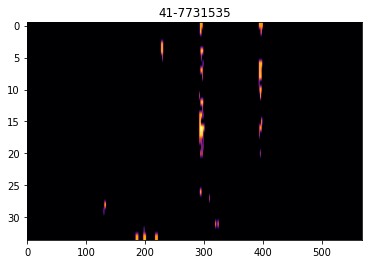

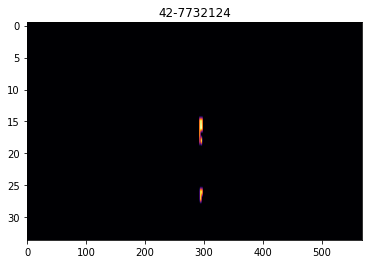

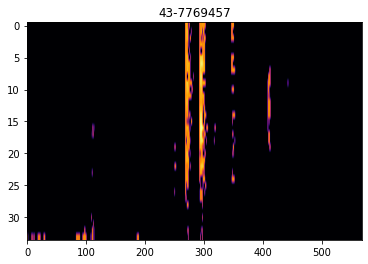

In [50]:
for i, peak in enumerate(p[0]):
    s_peak = s_all[:, peak: peak + s_temp.shape[1]]
    fig, ax = plt.subplots()
    ax.imshow(np.log(s_peak[::-1]), aspect='auto', cmap='inferno')
    ax.set_title('{}-{}'.format(i, peak))
    

##### Manually curate and confirm

In [51]:
curated_peaks = np.array([0, 1, 2, 3, 4, 5, 37, 38, 39, 40]).astype(np.int)
curated_peaks

array([ 0,  1,  2,  3,  4,  5, 37, 38, 39, 40])

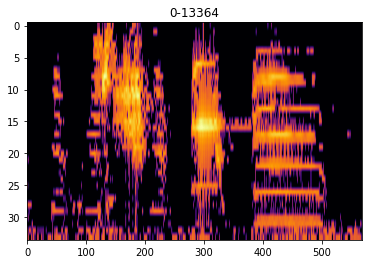

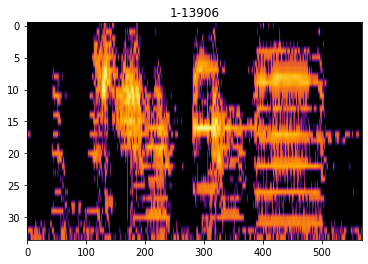

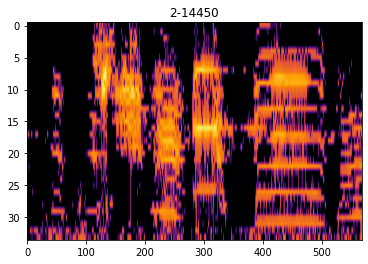

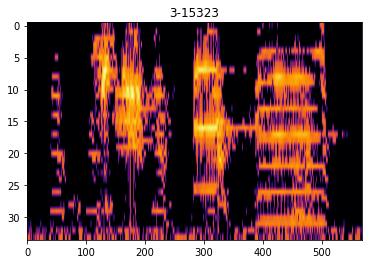

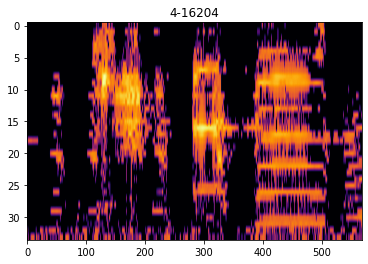

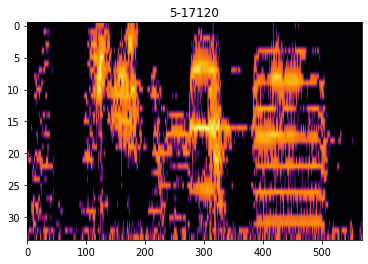

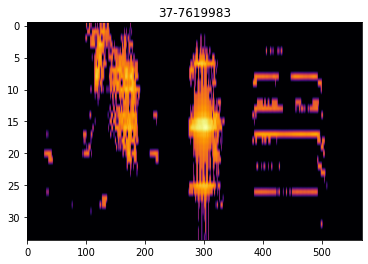

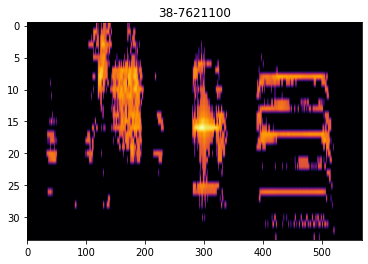

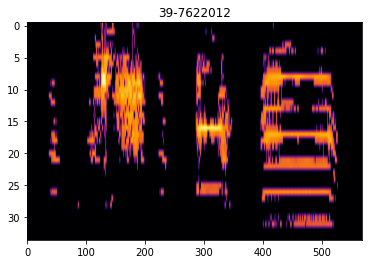

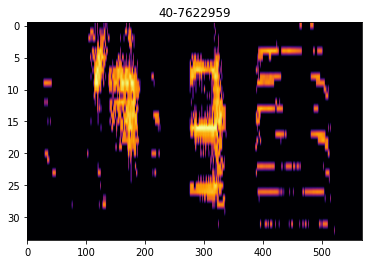

In [52]:
for i in curated_peaks:
    peak = p[0][i]
    s_peak = s_all[:, peak: peak + s_temp.shape[1]]
    fig, ax = plt.subplots()
    ax.imshow(np.log(s_peak[::-1]), aspect='auto', cmap='inferno')
    ax.set_title('{}-{}'.format(i, peak))

### The time syncronization

In [183]:
# t_0 is n/s_f (measured s_f)
# t_prime is interpolation to a t_ref (the nidaq, for instance, but it should be the one with the highest s_f)

In [53]:
def compute_sf(ttl: tuple) -> np.array:
    ttl_arr = np.array(ttl)
    
    # get all the diffs betwenn edge ups and edge donws
    all_diff_arr = np.concatenate([np.diff(ttl_arr[0, ttl_arr[1]==j]) for j in [-1, 1]])
    
    return all_diff_arr

np.mean(compute_sf(ap_syn_ttl))

30000.0

In [54]:
compute_sf(nidq_syn_ttl)

array([24999, 25000, 25000, 24999, 25000, 25000])

#### use the imec af as a pattern

In [55]:
signal = 'ap_0'

syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 120000, 0, [0], run_recordings[signal]._meta)

traces = run_recordings[signal].get_traces(end_frame=120000)
n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=120000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-01-30 19:45:51,215 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 19:45:51,220 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.00213333333333
2021-01-30 19:45:51,223 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 19:45:51,224 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 19:45:51,225 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.00213333333333


In [56]:
ttl_edge_tuple_pattern = ttl_edge_tuple
s_f_pattern = s_f
t_pattern = t_0
t_pattern_edge = t_0_edge
syn_stream_pattern = syn_stream

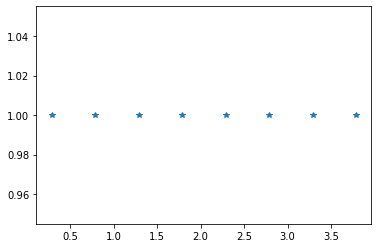

In [188]:
#plt.plot(t_0_edge, np.ones_like(t_0_edge), '*')

In [57]:
s_f_pattern, t_pattern, ttl_edge_tuple_pattern = run_recordings[signal].get_effective_sf()

In [58]:
ttl_edge_tuple_pattern[0].shape

(8,)

#### fit the nidaq to the pattern

In [59]:
signal = 'nidq'
traces = run_recordings[signal].get_traces(end_frame=100000)
syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 100000, 0, [0], run_recordings[signal]._meta)

n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=100000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-01-30 19:45:52,012 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [60]:
run_recordings[signal].syn_to_pattern(t_pattern, ttl_edge_tuple_pattern)

array([6.58613333e-05, 1.05858667e-04, 1.45856000e-04, ...,
       7.64158607e+03, 7.64158611e+03, 7.64158615e+03])

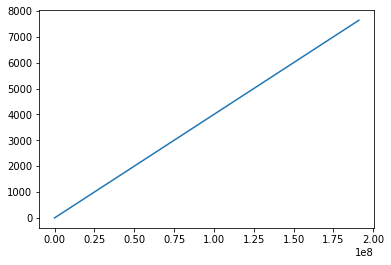

In [193]:
plt.plot(run_recordings[signal]._t_prime)

### make the time conversions using the syn_to_sgl_rec_exctractor method

In [61]:
run_recordings['lf_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-01-30 19:45:57,797 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 19:45:57,798 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 20:20:00,787 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.00288350326734
2021-01-30 20:23:48,402 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 20:23:48,403 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 20:25:48,539 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.00272

In [62]:
run_recordings['nidq'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-01-30 20:26:00,732 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 20:26:00,733 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 20:26:04,969 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.00288350326734
2021-01-30 20:26:13,241 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [63]:
run_recordings['ap_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-01-30 20:27:34,755 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 20:27:34,757 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 20:27:38,990 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.00288350326734
2021-01-30 20:27:43,426 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 20:27:43,428 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 20:27:46,028 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.00288

### Test the sync

##### plot all three times
should see different slopes, same end point

In [ ]:
# plt.plot(run_recordings['ap_0']._t_0, '.')
# plt.plot(run_recordings['ap_0']._t_prime)
# plt.plot(run_recordings['nidq']._t_prime)
# plt.plot(run_recordings['lf_0']._t_prime)

In [ ]:
# run_recordings['lf_0']._t_prime[-1]

In [ ]:
# run_recordings['ap_0']._t_prime[-1]

In [ ]:
# run_recordings['nidq']._t_prime[-1]

In [44]:
# raise KeyboardInterrupt

KeyboardInterrupt: 

### plot the square syn signals in the three different timescales

In [ ]:
# sig = 'lf_0'
# t_start_plot = 125

# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

# sig = 'ap_0'
# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

# sig = 'nidq'
# t_plot = run_recordings[sig]._t_prime > t_start_plot
# plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

### The sorting

In [64]:
se.installed_recording_extractor_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhyRecordingExtractor,
 spikeextractors.extractors.maxoneextractors.maxoneextractors.MaxOneRecordingExtractor,
 spikeextractors.extractors.mea1kextractors.mea1kextractors.Mea1kRecordingExtractor,
 spikeextractors.extractors.mcsh5recordingextractor.mcsh5rec

##### pick one ap stream, view it after running some of the toolkits

In [65]:
ap_extractor = run_recordings['ap_0']

###### view it raw

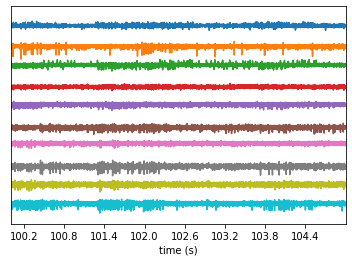

In [66]:
sw.plot_timeseries(ap_extractor, channel_ids=range(40, 50), trange=[100,105])

###### filtered

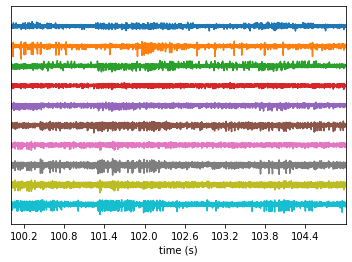

In [67]:
ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 50), trange=[100,105])

###### cmr

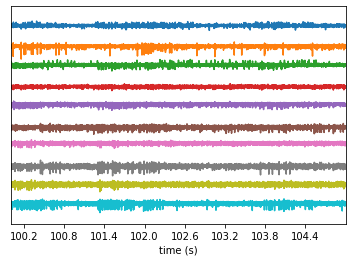

In [68]:
ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(40, 50), trange=[100,105])

In [69]:
exp_struct['folders']

{'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/2500r250a_3500_dir_g0',
 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g0',
 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/2500r250a_3500_dir_g0',
 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0',
 'derived': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/derived/20201104/2500r250a_3500_dir_g0',
 'tmp': '/scratch/earneodo/tmp/tmp/2500r250a_3500_dir_g0',
 'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104/2500r250a_3500_dir_g0',
 'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g0'}

In [75]:
import logging
import tempfile
import multiprocessing
import pickle
import os

N_JOBS_MAX = multiprocessing.cpu_count()

In [76]:
def run_spikesort(recording_extractor: se.RecordingExtractor, 
                  logger: logging.Logger,
                  sort_pickle_path: str,
                  tmp_dir: str, 
                  grouping_property: str=None,
                 sorting_method: str='kilosort2',
                 n_jobs_bin: int=N_JOBS_MAX,
                 chunk_mb: int=4096, restrict_to_gpu=None,
                 **sort_kwargs):

    logger.info("Grouping property: {}".format(grouping_property))
    logger.info("sorting method: {}".format(sorting_method))
    
    # try:
    if sorting_method == "kilosort2":
        # perform kilosort sorting
        sort_tmp_dir = os.path.join(tmp_dir, 'tmp_ks2')
        logger.info('Sorting tmp dir {}'.format(sort_tmp_dir))
        
        if restrict_to_gpu is not None:
            logger.info('Will set visible gpu devices {}'.format(restrict_to_gpu))
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)

            
        sort = ss.run_kilosort2(
            recording_extractor,
            car=True,
            output_folder=sort_tmp_dir,
            parallel=True,
            verbose=True,
            grouping_property=grouping_property,
            chunk_mb=chunk_mb,
            n_jobs_bin=n_jobs_bin,
            **sort_kwargs
        )
        
    else:
        raise NotImplementedError('Only know how to sort kilosort2 for now, \
                                        will deal with {} later'.format(sorting_method))
        
    logger.info('done sorting')
    
    # save sort
    logger.info("Saving sort {}".format(sort_pickle_path))
    with open(sort_pickle_path, "wb") as output:
        pickle.dump(sort, output, pickle.HIGHEST_PROTOCOL)
    logger.info("Sorting output saved to {}".format(sort_pickle_path))
      
#     # get templates and max channel
#     logger.info("Getting templates")
#     templates = st.postprocessing.get_unit_templates(
#         recording_extractor,
#         sort,
#         max_spikes_per_unit=200,
#         save_as_property=True,
#         verbose=True,
#         n_jobs=n_jobs_bin,
#         grouping_property=grouping_property,
#     )
    
#     logger.info("Getting main channel")
#     max_chan = st.postprocessing.get_unit_max_channels(
#         recording_extractor, 
#         sort, 
#         save_as_property=True, 
#         verbose=True, 
#         n_jobs=n_jobs_bin
#     )   
    
    # save sort again with all that processed data
    sort_temp_pickle_path = sort_pickle_path + '.dump.pkl'
    logger.info("Saving sort {}".format(sort_temp_pickle_path))
    sort.dump_to_pickle(sort_temp_pickle_path)
    
    return sort

In [68]:
ks_params = {'kilo_version': 2,
             'use_gpu': 1,
            'auto_merge': 1,
            'filt_per_chan': 4,
            's_f': int(s_f),
            'spkTh': -4,
            'minFR': 1/100,
            }

NameError: name 'n_chan' is not defined

In [70]:
default_ks2_params = ss.Kilosort2Sorter.default_params()
default_ks2_params

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'freq_min': 150,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [71]:
1/100

0.01

##### manually enter ksort params

In [77]:
ks2_params = {'minFR': 0.01,
             'minfr_goodchannels': 0.01}

In [78]:
tmp_loc = exp_struct['folders']['ksort']
tmp_loc

'/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g0'

In [79]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle')

sort = run_spikesort(ap_extractor, logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, **ks2_params)

2021-01-31 08:47:08,392 root         INFO     Grouping property: None
2021-01-31 08:47:08,393 root         INFO     sorting method: kilosort2
2021-01-31 08:47:08,394 root         INFO     Sorting tmp dir /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g0/tmp_ks2
2021-01-31 08:47:08,395 root         INFO     Will set visible gpu devices 1


kilosort2 run time 8838.74s


2021-01-31 11:29:22,117 root         INFO     done sorting
2021-01-31 11:29:22,120 root         INFO     Saving sort /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g0/sort_ks2.pickle
2021-01-31 11:30:07,137 root         INFO     Sorting output saved to /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g0/sort_ks2.pickle
2021-01-31 11:30:07,139 root         INFO     Saving sort /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g0/sort_ks2.pickle.dump.pkl


In [83]:
sort.get_epoch_names()

[]

### load the sort

In [81]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
sort_pickle_path

'/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g0/sort_ks2.pickle.dump.pkl'

In [90]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
print(sort_pickle_path)
loaded_sort = se.load_extractor_from_pickle(sort_pickle_path)

/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g0/sort_ks2.pickle.dump.pkl


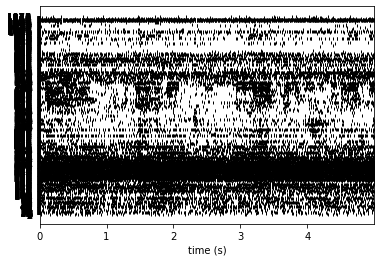

In [91]:
w_rs = sw.plot_rasters(loaded_sort, trange=[0,5])

In [101]:
u_wf = st.postprocessing.get_unit_waveforms(ap_extractor_filt, loaded_sort, unit_ids=[0, 1], 
                                            ms_before=0.5, ms_after=0.5,
                                          save_as_features=True, verbose=True,
                                           **{'n_jobs': 40,
                                           'max_spikes_per_unit': 100})

Number of chunks: 14087 - Number of jobs: 40


In [106]:
u_wf[0].shape

(100, 384, 28)

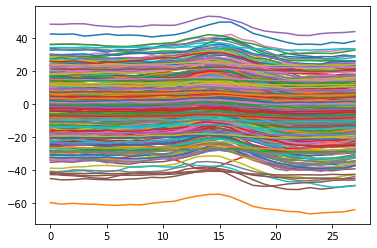

In [111]:
plt.plot(u_wf[1].mean(axis=0).T);

In [115]:
u_wf = st.postprocessing.get_unit_max_channels(ap_extractor_filt, loaded_sort, unit_ids=[0, 1], 
                                            ms_before=0.5, ms_after=0.5,
                                          save_as_features=True, verbose=True,
                                           **{'n_jobs': 40,
                                           'max_spikes_per_unit': 100})

Number of chunks: 14087 - Number of jobs: 40
Number of chunks: 14087 - Number of jobs: 40


In [98]:
all_unit_id = np.array(loaded_sort.get_unit_ids())

In [99]:
loaded_sort.get_unit_property(5, 'pc_features')

ValueError: pc_features has not been added to unit 5

In [119]:
u_wf

[0, 0]

In [116]:
loaded_sort.get_shared_unit_spike_feature_names(unit_ids=[0,1])

['amplitudes', 'pc_features', 'waveforms', 'waveforms_idxs']

In [54]:
snrs = st.validation.compute_snrs(loaded_sort, ap_extractor)


In [56]:
isi_violations = st.validation.compute_isi_violations(loaded_sort, 
                                                      duration_in_frames=ap_extractor.get_num_frames())

In [58]:
wf = st.postprocessing.get_unit_waveforms(ap_extractor, loaded_sort, ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)

In [60]:
wf[0].shape

(1000, 384, 178)

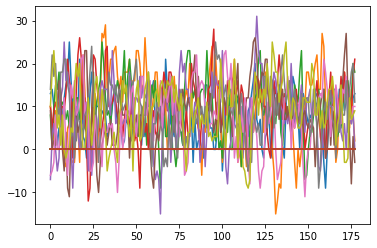

In [86]:
plt.plot(wf[13][:, 0, :].T);

In [72]:
max_chan = st.postprocessing.get_unit_max_channels(ap_extractor, loaded_sort, save_as_property=True, verbose=True)

In [86]:
templates = st.postprocessing.get_unit_templates(ap_extractor, loaded_sort, save_as_property=True, verbose=True)

Number of chunks: 353 - Number of jobs: 1


KeyboardInterrupt: 

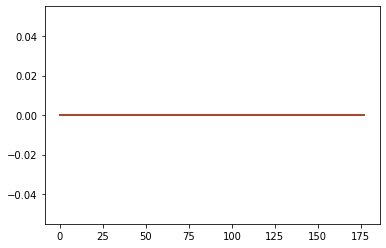

In [90]:
plt.plot(templates[0].T);

In [78]:
np.where(np.array(max_chan)>0)

(array([  5,  13,  23,  36,  44,  59,  72,  73,  84, 117, 126, 200, 250,
        259]),)

In [85]:
loaded_sort.get_unit_property(15, 'max_channel')

ValueError: max_channel has not been added to unit 15

### load the npy objects from kilosort

In [92]:
spk_clu = np.load(os.path.join(tmp_loc, 'tmp_ks2', 'spike_clusters.npy'))
spk_templates = np.load(os.path.join(tmp_loc, 'tmp_ks2', 'templates.npy'))

In [97]:
np.unique(spk_clu).shape

(272,)

In [93]:
spk_templates.shape

(314, 82, 371)

## Try with sglexp
make a pandas dataframe to keep track of epochs (folders), runs within each session, caryying the recording extractors

In [122]:
from ceciestunepipe.util import sglxexp as sgle

In [126]:
reload(sgle)
epoch_pd = sgle.make_sgl_epoch_dict(sess_par, sess_epochs[1])

In [127]:
epoch_pd

bird      sess  run  \
0  z_w12m7_20  20201104    0   

                                                nidq  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                                lf_0  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                                ap_0  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                            rec-nidq  \
0  <ceciestunepipe.util.spikeextractors.extractor...   

                                            rec-lf_0  \
0  <ceciestunepipe.util.spikeextractors.extractor...   

                                            rec-ap_0  
0  <ceciestunepipe.util.spikeextractors.extractor...

In [138]:
reload(sgle)
sess_pd = sgle.make_session_pd(sess_par)
sess_pd

2021-01-28 11:52:14,246 ceciestunepipe.util.sglxutil INFO     {'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20', 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104', 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104', 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104', 'tmp': '/scratch/earneodo/tmp/tmp', 'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104', 'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104'}, 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/params.json', 'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf', 'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json', 'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/stream.kwd', 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/sort_2/

bird      sess                  epoch  run  \
0  z_w12m7_20  20201104  2500r250a_3500_dir_g0    0   
1  z_w12m7_20  20201104  2500r250a_3500_dir_g1    0   
2  z_w12m7_20  20201104  2500r250a_3500_dir_g2    0   

                                                nidq  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
1  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
2  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                                lf_0  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
1  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
2  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                                ap_0  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
1  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
2  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                            rec-nidq  \
0  <ceciestunepipe.util.spikeextractors.extractor...   
1  <ceciestunepipe.util.spikeextractors.extractor...   
2  <ceciestunepipe.util.spikeextractors.extractor...   

                                            rec-lf_0  \
0  <ceciestunepipe.util.spikeextractors.extractor...   
1  <ceciestunepipe.util.spikeextractors.extractor...   
2  <ceciestunepipe.util.spikeextractors.extractor...   

                                            rec-ap_0  
0  <ceciestunepipe.util.spikeextractors.extractor...  
1  <ceciestunepipe.util.spikeextractors.extractor...  
2  <ceciestunepipe.util.spikeextractors.extractor...

### get some metadata

In [137]:
def get_sess_pd_meta(sess_pd: pd.DataFrame) -> pd.DataFrame:
    # fields to pick from the sglx metadata
    sglx_fields = {}
    

bird      sess                  epoch  run  \
0  z_w12m7_20  20201104  2500r250a_3500_dir_g0    0   
1  z_w12m7_20  20201104  2500r250a_3500_dir_g1    0   
2  z_w12m7_20  20201104  2500r250a_3500_dir_g2    0   

                                                nidq  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
1  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
2  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                                lf_0  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
1  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
2  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                                ap_0  \
0  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
1  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   
2  /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...   

                                            rec-nidq  \
0  <ceciestunepipe.util.spikeextractors.extractor...   
1  <ceciestunepipe.util.spikeextractors.extractor...   
2  <ceciestunepipe.util.spikeextractors.extractor...   

                                            rec-lf_0  \
0  <ceciestunepipe.util.spikeextractors.extractor...   
1  <ceciestunepipe.util.spikeextractors.extractor...   
2  <ceciestunepipe.util.spikeextractors.extractor...   

                                            rec-ap_0  
0  <ceciestunepipe.util.spikeextractors.extractor...  
1  <ceciestunepipe.util.spikeextractors.extractor...  
2  <ceciestunepipe.util.spikeextractors.extractor...

### sort a merged recording extractor with all of the session epochs, runs

In [193]:
def merge_pd(sess_pd: pd.DataFrame) -> pd.DataFrame:
    
    # get the list of existing recordings (one per stream)
    rec_list = [c for c in (sess_pd.columns) if 'rec' in c]
    
    # merge each column
    merged_rec_dict = {c: se.MultiRecordingTimeExtractor(recordings=list(sess_pd.loc[:, c].values)) for c in rec_list}
    
    merged_pd = pd.DataFrame.from_dict(merged_rec_dict, orient='index').T
    merged_pd['bird'] = sess_pd['bird']
    merged_pd['sess'] = sess_pd['sess']
    merged_pd['epoch'] = [list(sess_pd.loc[:, 'epoch'].values)]*len(merged_pd)
    merged_pd['run'] = [list(sess_pd.loc[:, 'run'].values)]*len(merged_pd)
    
    return merged_pd

reload(sgle)
merged_pd = sgle.merge_session_pd(sess_pd)

In [194]:
merged_pd

rec-nidq  \
0  <spikeextractors.multirecordingtimeextractor.M...   

                                            rec-lf_0  \
0  <spikeextractors.multirecordingtimeextractor.M...   

                                            rec-ap_0        bird      sess  \
0  <spikeextractors.multirecordingtimeextractor.M...  z_w12m7_20  20201104   

                                               epoch        run  
0  [2500r250a_3500_dir_g0, 2500r250a_3500_dir_g1,...  [0, 0, 0]

In [195]:
merged_pd.loc[0, 'rec-lf_0']

In [197]:
merged_exp_struct = sglu.sgl_struct(sess_par, 'merge')
merged_exp_struct

{'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/merge',
  'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/merge',
  'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/merge',
  'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/merge',
  'tmp': '/scratch/earneodo/tmp/tmp/merge',
  'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104/merge',
  'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge'},
 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge/params.json',
  'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf',
  'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json',
  'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/merge/stream.kwd',
  'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/202

In [198]:
tmp_loc

'/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g2'

In [ ]:
sort_pickle_path = os.path.join(merged_exp_struct['folders']['ksort'], 'sort_ks2.pickle')
tmp_loc = merged_exp_struct['folders']['ksort']

sort = run_spikesort(merged_pd.loc[0, 'rec-ap_0'], logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, **ks2_params)

2021-01-28 23:56:25,540 root         INFO     Grouping property: None
2021-01-28 23:56:25,542 root         INFO     sorting method: kilosort2
2021-01-28 23:56:25,543 root         INFO     Sorting tmp dir /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge/tmp_ks2
2021-01-28 23:56:25,545 root         INFO     Will set visible gpu devices 1


In [80]:
sort